In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error

# import data

In [3]:
df= pd.read_csv("Dummy Data HSS.csv")
df.head(3)

,TV,Radio,Social Media,Sales
0,16.0,6.566231,2.907983,54.732757
1,13.0,9.237765,2.409567,46.677897
2,41.0,15.886446,2.913410,150.177829


# basic EDA

In [4]:
df.shape

(4572, 4)

In [5]:
df= df.dropna(how= "any")

In [6]:
df.shape

(4546, 4)

In [7]:
df.describe()

,TV,Radio,Social Media,Sales
count,4546.000000,4546.000000,4546.000000,4546.000000
mean,54.062912,18.157533,3.323473,192.413332
std,26.104942,9.663260,2.211254,93.019873
min,10.000000,0.000684,0.000031,31.199409
25%,32.000000,10.555355,1.530822,112.434612
50%,53.000000,17.859513,3.055565,188.963678
75%,77.000000,25.640603,4.804919,272.324236
max,100.000000,48.871161,13.981662,364.079751


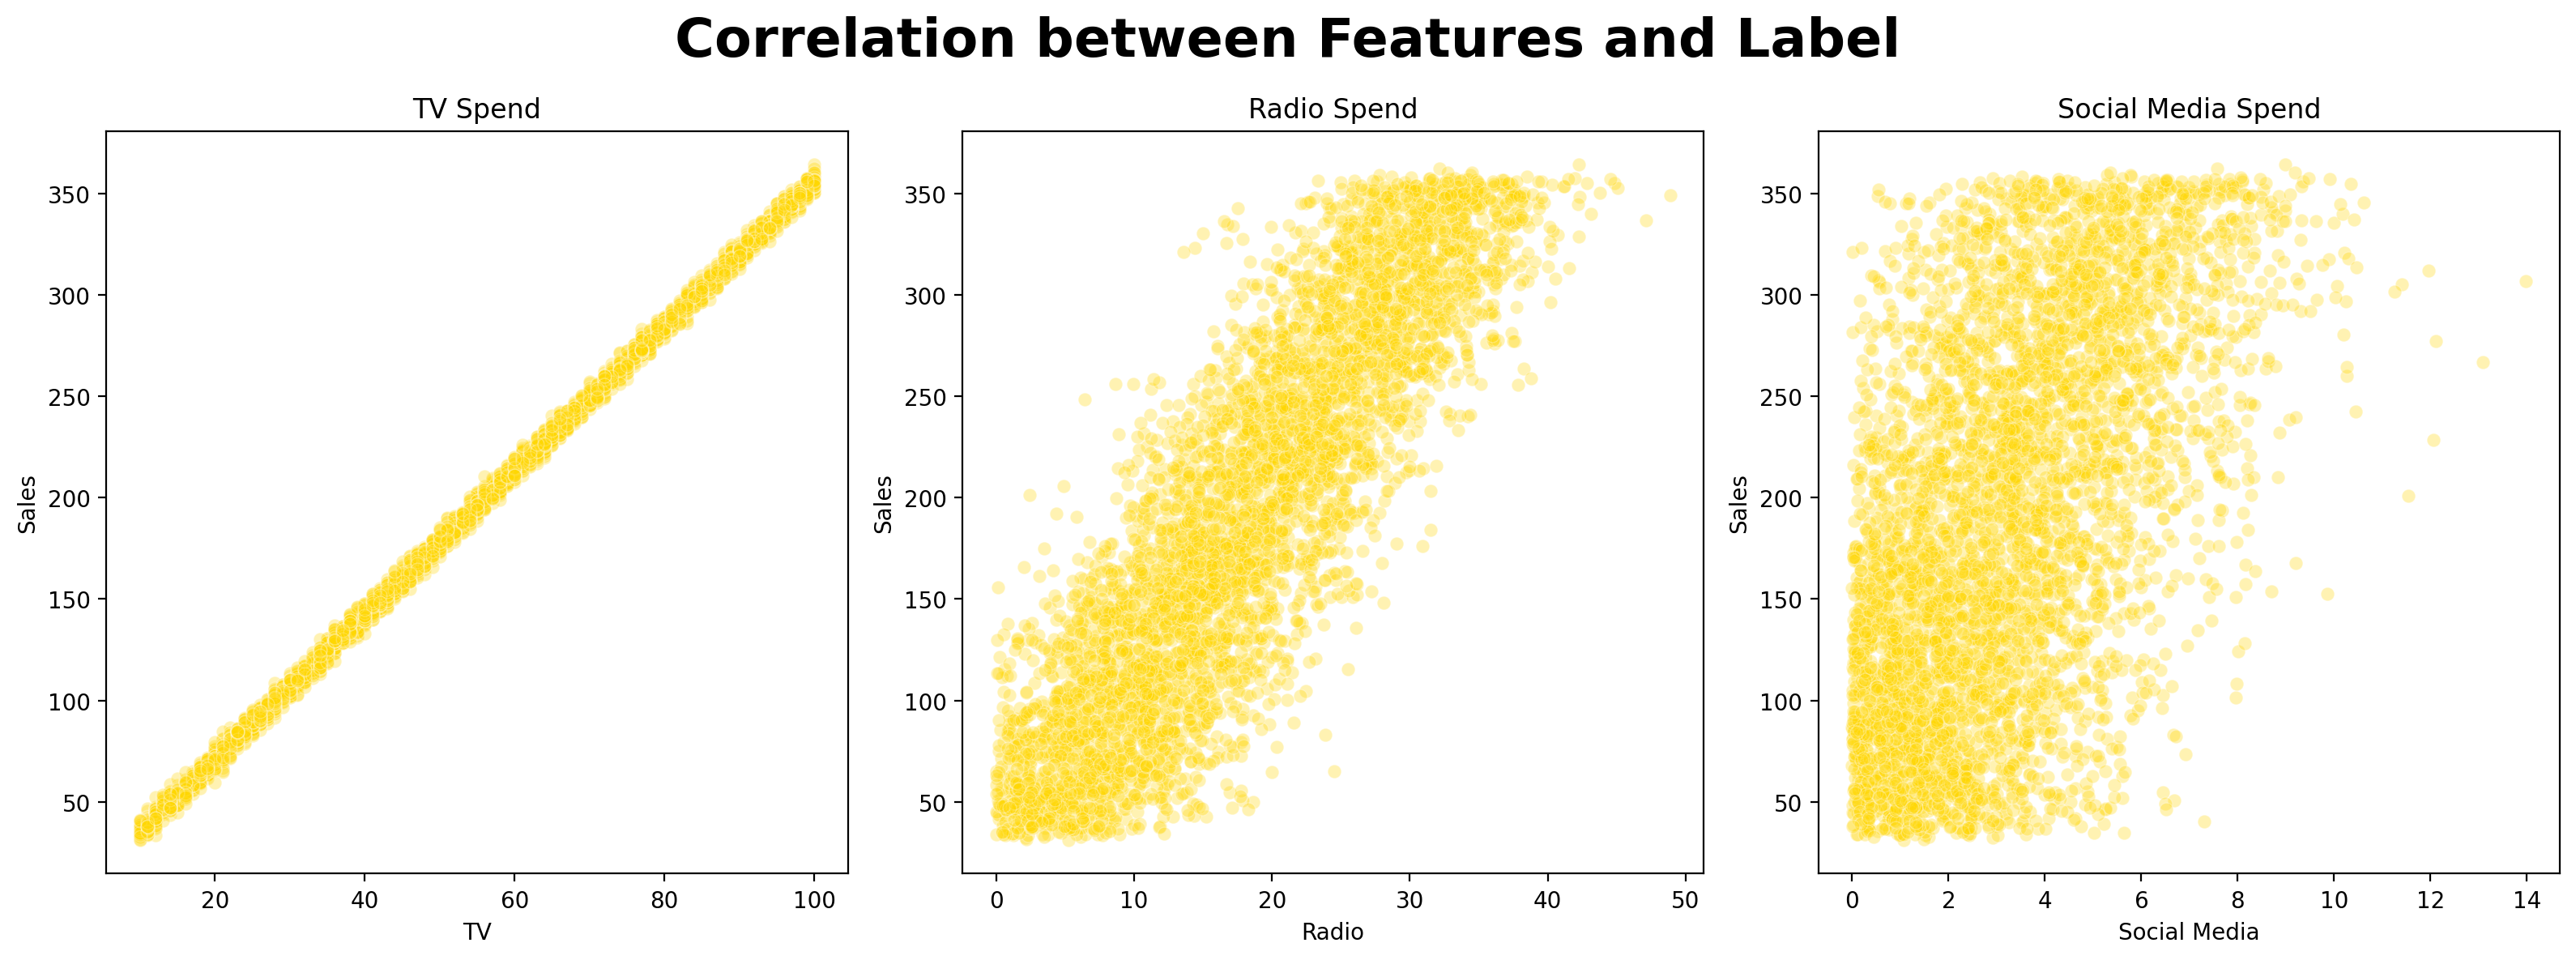

In [41]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(16,6), dpi= 200)

with sns.axes_style("whitegrid", {"grid.color": ".9", "grid.linestyle": ":"}):

    sns.scatterplot(x= df['TV'], y= df['Sales'], ax=axes[0], alpha= 0.3, color= "#ffd700")
    axes[0].set_ylabel("Sales")
    axes[0].set_title("TV Spend")

    sns.scatterplot(x= df['Radio'], y= df['Sales'], ax=axes[1], alpha= 0.3, color= "#ffd700")
    axes[1].set_title("Radio Spend")
    axes[1].set_ylabel("Sales")

    sns.scatterplot(x= df['Social Media'], y= df['Sales'], ax=axes[2], alpha= 0.3, color= "#ffd700")
    axes[2].set_title("Social Media Spend");
    axes[2].set_ylabel("Sales")

plt.suptitle("Correlation between Features and Label", fontsize= 24, fontweight= "bold")
plt.tight_layout()
plt.show()

**Seems like TV spending correlates very strongly with sales. We will later each coefficient.**

# check RMSE for various poly degress

In [9]:
X= df.drop("Sales", axis= "columns")
y= df["Sales"]

In [10]:
train_rmse_list= []
test_rmse_list= []

for d in range(1, 10):
    poly_converter= PolynomialFeatures(degree= d, include_bias= False)
    poly_features= poly_converter.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(
    poly_features, y, test_size=0.3, random_state=101)
    
    model= LinearRegression()
    model.fit(X_train, y_train)
    train_prediction= model.predict(X_train)
    test_prediction= model.predict(X_test)
    
    train_rmse= np.sqrt(mean_squared_error(y_train, train_prediction))
    test_rmse= np.sqrt(mean_squared_error(y_test, test_prediction))
    
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

In [40]:
pd.DataFrame({"Degree": range(1, 10), "Train RMSE": train_rmse_list, "Test RMSE": test_rmse_list})

,Degree,Train RMSE,Test RMSE
0,1,2.968856,2.901285
1,2,2.966457,2.900707
2,3,2.958405,2.914039
3,4,2.952385,2.919956
4,5,2.942291,2.935605
5,6,2.925408,2.973931
6,7,2.909550,3.013327
7,8,3.372150,4.131094
8,9,79.199116,208.534782


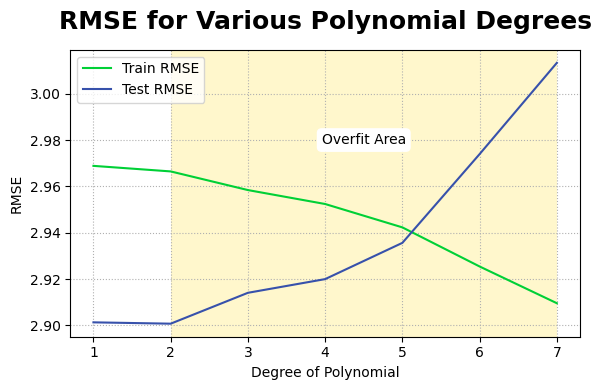

In [63]:
plt.figure(figsize= (6, 4), dpi= 100)
plt.grid(linestyle= ":")

plt.plot(range(1, 8), train_rmse_list[:7], label= "Train RMSE", color= "#00d036")
plt.plot(range(1, 8), test_rmse_list[:7], label= "Test RMSE", color= "#3751ab")

plt.axvspan(2, 7, facecolor='#ffd700', alpha=0.2)
plt.text(4.5, 2.98, "Overfit Area", bbox=dict(boxstyle="round", color= "white"), 
         horizontalalignment='center', verticalalignment='center',)
         
plt.xlabel("Degree of Polynomial")
plt.ylabel("RMSE")
plt.legend()
plt.title("RMSE for Various Polynomial Degrees", fontsize= 18, fontweight= "bold", pad= 15)
plt.tight_layout()
#plt.savefig("rmse.png", dpi= 300)
plt.show()

**As shown above, we will select degree of 2. Above that degree, there is a clear indication of overfitting.**

# polynomial feature

In [14]:
# Generate a new feature matrix consisting of all polynomial combinations of the features (degree 2)
poly_converter= PolynomialFeatures(degree= 2, include_bias= False)

In [15]:
# fit and transform x
poly_converter.fit(X)
poly_features= poly_converter.transform(X)

In [16]:
X.shape

(4546, 3)

In [17]:
poly_features.shape

(4546, 9)

# ML model

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    poly_features, y, test_size=0.3, random_state=101)

In [19]:
model= LinearRegression()
model.fit(X_train, y_train)

test_prediction= model.predict(X_test)

In [20]:
poly_features= poly_converter.get_feature_names(df.columns)

pd.DataFrame({"Feature": poly_features, "Coefficient": model.coef_})

,Feature,Coefficient
0,TV,3.549759
1,Radio,0.010153
2,Social Media,0.021205
3,TV^2,0.000019
4,TV Radio,0.001258
5,TV Social Media,-0.003392
6,Radio^2,-0.002777
7,Radio Social Media,0.006287
8,Social Media^2,0.005707


**TV coefficient is the strongest.**

# performance evaluation

In [21]:
mae= mean_absolute_error(y_test, test_prediction)
mse= mean_squared_error(y_test, test_prediction)
rmse= np.sqrt(mean_squared_error(y_test, test_prediction))
sales_mean= df["Sales"].mean()
error_percentage= (mae/sales_mean)*100

print(f"MAE= {mae}")
print(f"MSE= {mse}")
print(f"RMSE= {rmse}")
print(f"Average Error Percentage= {np.round(error_percentage, 3)} %")

MAE= 2.3427552169676753
MSE= 8.41410225846327
RMSE= 2.900707199712386
Average Error Percentage= 1.218 %


In [22]:
test_residual= y_test - test_prediction

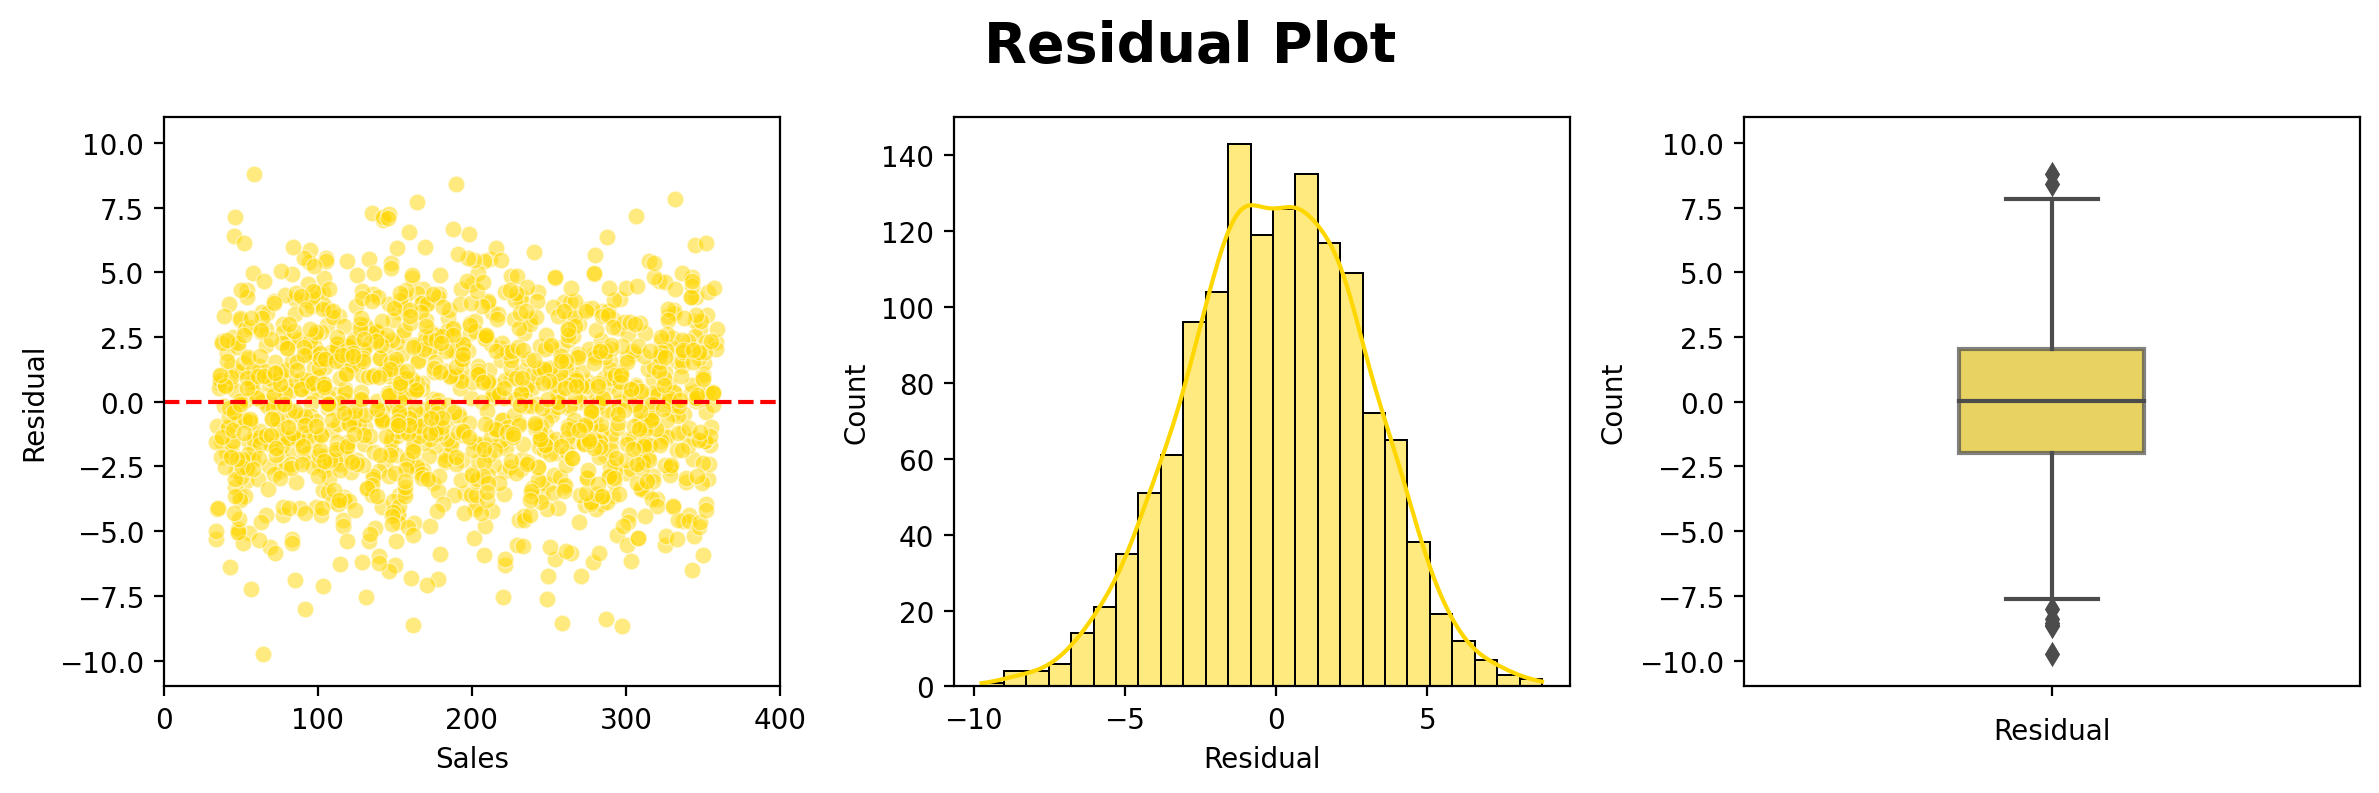

In [62]:
fig, ax = plt.subplots(ncols=3, figsize= (12,4), dpi= 200)

sns.scatterplot(x= y_test, y= test_residual, ax= ax[0], color= "#ffd700", alpha= 0.5)
ax[0].set_xlim(0, 400)
ax[0].set_ylim(-11, 11)
ax[0].axhline(y= 0, color= "red", linestyle= "--")
ax[0].set_ylabel("Residual")
ax[0].set_xlabel("Sales")

sns.histplot(test_residual, bins= 25, kde= True, ax= ax[1], color= "#ffd700")
ax[1].set_xlabel("Residual")

sns.boxplot(y= test_residual, color= "#ffd700", ax= ax[2], boxprops=dict(alpha=.7), width=0.3)
ax[2].set_ylim(-11, 11)
ax[2].set_xlabel("Residual")
ax[2].set_ylabel("Count")


plt.suptitle("Residual Plot", fontsize= 20, fontweight= "bold")
plt.tight_layout()
plt.show()

# deploy model

In [24]:
final_poly_converter= PolynomialFeatures(degree= 3, include_bias= False)
final_poly_model= LinearRegression()

In [25]:
full_converted_x= final_poly_converter.fit_transform(X)
final_poly_model.fit(full_converted_x, y)

LinearRegression()

In [26]:
from joblib import dump, load

In [27]:
dump(final_poly_model, "final_poly_model.joblib")
dump(final_poly_converter, "final_poly_converter.joblib")

['final_poly_converter.joblib']

In [28]:
loaded_converter= load("final_poly_converter.joblib")
loaded_model= load("final_poly_model.joblib")

# test loaded model

In [45]:
campaign= [[160, 56, 37]]
campaign_converted= loaded_converter.fit_transform(campaign)
loaded_model.predict(campaign_converted)

array([493.83902962])